# DLT(Direct linear transformation)
参照URL : https://sportict.jp/3dlt-1/

## 既知の実空間座標(X, Y, Z)
1. TL (0, 0, 0)
2. TR (0, 900, 0)
3. BR (1800, 900, 0)
4. BL (1800, 0, 0)
5. 青ペン (0, 0, 140)
6. 赤ペン (0, 900, 140)

In [3]:
# install package
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy
from IPython.display import clear_output

%matplotlib notebook

In [30]:
# 画像クラス
class Picture:
    def __init__(self, imgPath, realCoords, imgCoords=[]):
        if os.path.isfile(imgPath):
            self.img = cv2.imread(imgPath)
            self.iCoords = imgCoords
            self.rCoords = realCoords
            self.X = []
            self.U = []
            self.L = []
            # 関数処理
            if imgCoords==[]:
                self.getICoords() # 画像座標取得
            self.dltMatrix() # DLTパラメータ算出
        else:
            raise Exception("ファイル：{}が存在しません".format(imgPath))
    
    # 画像表示
    def imshow(self):
        plt.imshow(cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB))
    
    # OpenCV用関数
    def imgClick(self, event, u, v, flags, params):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.iCoords.append([u, v])
            print(len(self.iCoords), [u, v])
        elif event == cv2.EVENT_RBUTTONDOWN:
            self.iCoords = []
    
    def getICoords(self):
        cv2.imshow("Calibration", self.img)
        cv2.setMouseCallback("Calibration", self.imgClick)
        cv2.waitKey()
        cv2.destroyAllWindows()
    # DLTパラメータ用関数
    def uArray(self, i):
        u = self.iCoords[i][0]
        return [self.rCoords[i][0], self.rCoords[i][1], self.rCoords[i][2], 1, 0, 0, 0, 0, -u*self.rCoords[i][0], -u*self.rCoords[i][1], -u*self.rCoords[i][2]]
    
    def vArray(self, i):
        v = self.iCoords[i][1]
        return [0, 0, 0, 0, self.rCoords[i][0], self.rCoords[i][1], self.rCoords[i][2], 1, -v*self.rCoords[i][0], -v*self.rCoords[i][1], -v*self.rCoords[i][2]]
    
    def dltMatrix(self):
        pointNum = len(self.iCoords)
        # 計測行列X
        for index in range(pointNum):
            self.X.append(self.uArray(index))
            self.X.append(self.vArray(index))
        self.X = np.array(self.X)
        # 座標画像ベクトルU
        self.U = np.array(sum(self.iCoords, []))
        # DLTパラメータ
        tX = self.X.transpose(1, 0) #Xの転置行列
        self.L = np.dot(np.dot(np.linalg.inv(np.dot(tX, self.X)), tX), self.U)

In [45]:
# 実空間座標C(X, Y, Z)を求めたい
# A, Bを以下で求められ、AC = Bより求まる
def getAMatrix(p1, p2, iCoord1, iCoord2):
    u1, v1 = iCoord1
    u2, v2 = iCoord2
    A = np.array(
        [
            [p1.L[0]-p1.L[8]*u1, p1.L[1]-p1.L[9]*u1, p1.L[2]-p1.L[10]*u1],
            [p1.L[4]-p1.L[8]*v1, p1.L[5]-p1.L[9]*v1, p1.L[6]-p1.L[10]*v1],
            [p2.L[0]-p2.L[8]*u2, p2.L[1]-p2.L[9]*u2, p2.L[2]-p2.L[10]*u2],
            [p2.L[4]-p2.L[8]*v2, p2.L[5]-p2.L[9]*v2, p2.L[6]-p2.L[10]*v2]
        ]
    )
    print("A", A)
    return A

def getBVector(p1, p2, iCoord1, iCoord2):
    u1, v1 = iCoord1
    u2, v2 = iCoord2
    B = np.array(
        [u1-p1.L[3], v1-p1.L[7], u2-p2.L[3], v2-p2.L[7]]
    )
    return B

def get3dCoord(p1, p2, iCoord1, iCoord2):
    A = getAMatrix(p1, p2, iCoord1, iCoord2)
    B = getBVector(p1, p2, iCoord1, iCoord2)
    tA = A.transpose(1, 0) # Aの転置行列
    C = np.dot(np.dot(np.linalg.inv(np.dot(tA, A)), tA), B)
    return C

In [55]:
# キャリブレーション用既知点
REALCOORDS = [
    [0, 0, 0],
    [0, 900, 0],
    [1800, 900, 0],
    [1800, 0, 0],
    [0, 0, 140],
    [0, 900, 140],
    [900, 0, 0], # コート中央
    [900, 900, 0] # コート中央
]
PATH1 = "./images/original1.png"
PATH2 = "./images/original2.png"

pic1 = Picture(PATH1, REALCOORDS, [[636, 140], [26, 149], [114, 1045], [1220, 908], [643, 49], [23, 52], [842, 412], [59, 447]])
pic2 = Picture(PATH2, REALCOORDS, [[1061, 115], [474, 200], [17, 1048], [1082, 1035], [1051, 19], [452, 113], [1069, 430], [316, 500]])

<IPython.core.display.Javascript object>


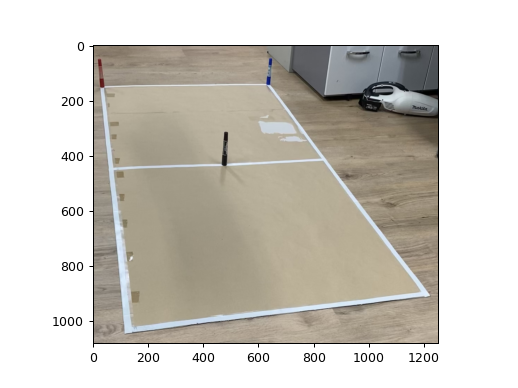

In [53]:
pic1.imshow()
iCoord1 = (636, 140)

<IPython.core.display.Javascript object>


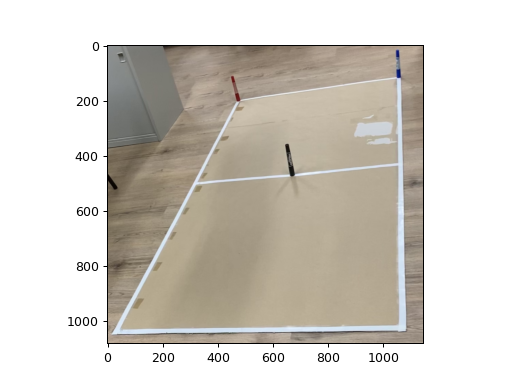

In [54]:
pic2.imshow()
iCoord2 = (1061, 115)

In [56]:
get3dCoord(pic1, pic2, iCoord1, iCoord2)

A [[-0.235273   -1.09444593 -1.64552692]
 [-0.1120752   0.10123037 -5.31482924]
 [-0.57927164 -0.98294177 -2.24470969]
 [ 0.05234342  0.06740164 -4.27257114]]
[[-0.235273   -1.09444593 -1.64552692]
 [-0.1120752   0.10123037 -5.31482924]
 [-0.57927164 -0.98294177 -2.24470969]
 [ 0.05234342  0.06740164 -4.27257114]]
A [[-0.235273   -1.09444593 -1.64552692]
 [-0.1120752   0.10123037 -5.31482924]
 [-0.57927164 -0.98294177 -2.24470969]
 [ 0.05234342  0.06740164 -4.27257114]]


array([-198.59013871,  315.86425299,  128.3912759 ])